In [931]:
#boundry detection by Computer Vision 

Analyzing full body motion characteristics...
Detecting sign boundaries based on pose changes...
Plotting motion analysis...


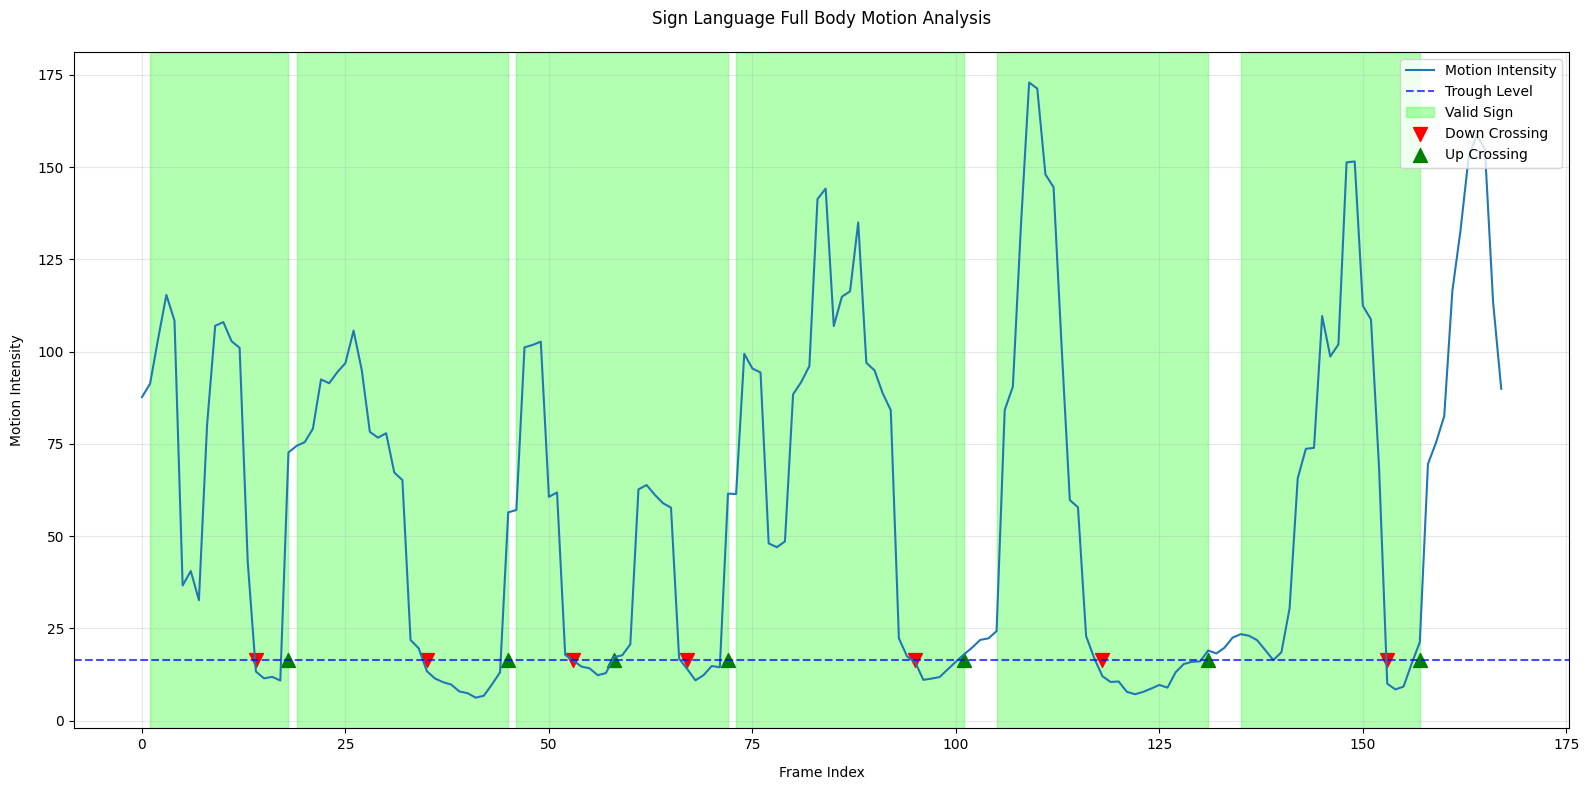


Found 6 valid sign segments

Sign Segment Frame Counts:
Sign 1: 18 frames (Duration: 0.57s)
Sign 2: 27 frames (Duration: 0.87s)
Sign 3: 27 frames (Duration: 0.87s)
Sign 4: 29 frames (Duration: 0.93s)
Sign 5: 27 frames (Duration: 0.87s)
Sign 6: 23 frames (Duration: 0.73s)

Saving sign segments...
Saved segment 1 to My_Videos/Saved_clips/vid1.mp4
Saved segment 2 to My_Videos/Saved_clips/vid2.mp4
Saved segment 3 to My_Videos/Saved_clips/vid3.mp4
Saved segment 4 to My_Videos/Saved_clips/vid4.mp4
Saved segment 5 to My_Videos/Saved_clips/vid5.mp4
Saved segment 6 to My_Videos/Saved_clips/vid6.mp4

Playing Sign 1:
Time 0:00:00.033 - 0:00:00.599
Duration: 0.57s
Press 'q' to stop playback or any other key to continue

Playing Sign 2:
Time 0:00:00.632 - 0:00:01.498
Duration: 0.87s
Press 'q' to stop playback or any other key to continue

Playing Sign 3:
Time 0:00:01.531 - 0:00:02.397
Duration: 0.87s
Press 'q' to stop playback or any other key to continue

Playing Sign 4:
Time 0:00:02.431 - 0:00:0

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import mediapipe as mp
from collections import deque

# Initialize MediaPipe solutions
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose

hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.8,
    min_tracking_confidence=0.8
)

pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.5
)

mp_drawing = mp.solutions.drawing_utils

def extract_landmarks(results_hands, results_pose):
    """Extracts all landmarks (hands and pose) into a flat array"""
    landmarks = []
    
    # Extract hand ACHUlandmarks (21 per hand, x,y,z coordinates)
    if results_hands.multi_hand_landmarks:
        for hand_landmarks in results_hands.multi_hand_landmarks:
            landmarks.extend([(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])
    else:
        landmarks.extend([(0, 0, 0)] * 42)
    
    if len(landmarks) < 42:
        landmarks.extend([(0, 0, 0)] * (42 - len(landmarks)))
    elif len(landmarks) > 42:
        landmarks = landmarks[:42]
    
    # Extract pose landmarks (33 landmarks, x,y,z,visibility)
    if results_pose.pose_landmarks:
        pose_landmarks = results_pose.pose_landmarks.landmark
        landmarks.extend([(lm.x, lm.y, lm.z, lm.visibility) for lm in pose_landmarks])
    else:
        landmarks.extend([(0, 0, 0, 0)] * 33)
    
    flat_landmarks = []
    for point in landmarks:
        if len(point) == 3:
            flat_landmarks.extend(point)
        else:
            flat_landmarks.extend(point[:4])
    
    return flat_landmarks

def compute_pose_difference(prev_landmarks, curr_landmarks, hand_only=True):
    """Compute the max difference in hand/finger poses between frames"""
    if prev_landmarks is None or len(prev_landmarks) != len(curr_landmarks):
        return 0.0
    
    end_idx = 126 if hand_only else len(prev_landmarks)
    diff = 0.0
    count = 0
    
    for i in range(0, end_idx, 3):
        px, py, pz = prev_landmarks[i:i+3]
        cx, cy, cz = curr_landmarks[i:i+3]
        if (px, py, pz) == (0, 0, 0) and (cx, cy, cz) == (0, 0, 0):
            continue
        diff = max(diff, np.sqrt((cx - px)**2 + (cy - py)**2 + (cz - pz)**2))
        count += 1
    
    return diff if count > 0 else 0.0

def analyze_motion_profile(video_path, smooth_window=5, pose_window=3):
    """Analyzes video motion characteristics and stores landmarks for pose analysis"""
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()
    if not ret:
        raise ValueError("Could not read video")
    
    prev_frame_rgb = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2RGB)
    prev_landmarks = None
    motion_values = []
    landmark_history = deque(maxlen=pose_window)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results_hands = hands.process(frame_rgb)
        results_pose = pose.process(frame_rgb)
        
        current_landmarks = extract_landmarks(results_hands, results_pose)
        landmark_history.append(current_landmarks)
        
        if prev_landmarks is not None and len(prev_landmarks) == len(current_landmarks):
            motion = 0
            for i in range(0, len(current_landmarks), 3):
                prev_x, prev_y, prev_z = prev_landmarks[i], prev_landmarks[i+1], prev_landmarks[i+2]
                curr_x, curr_y, curr_z = current_landmarks[i], current_landmarks[i+1], current_landmarks[i+2]
                motion += np.sqrt((curr_x - prev_x)**2 + (curr_y - prev_y)**2 + (curr_z - prev_z)**2)
            
            motion /= (len(current_landmarks) // 3)
            motion *= 1000
        else:
            motion = 0
            
        prev_landmarks = current_landmarks
        motion_values.append(motion)
    
    cap.release()
    
    smoothed = np.convolve(motion_values, np.ones(smooth_window)/smooth_window, mode='same')
    peaks, troughs = find_peaks_and_troughs(smoothed)
    
    global_avg = np.mean(smoothed)
    peak_avg = np.mean([smoothed[i] for i in peaks]) if peaks else global_avg
    trough_avg = np.mean([smoothed[i] for i in troughs]) if troughs else global_avg
    motion_range = peak_avg - trough_avg
    
    return {
        'motion_values': smoothed,
        'global_avg': global_avg,
        'peak_avg': peak_avg,
        'trough_avg': trough_avg,
        'motion_range': motion_range,
        'frame_indices': list(range(len(smoothed))),
        'landmark_history': list(landmark_history)
    }

def find_peaks_and_troughs(values, lookahead=5):
    """Identifies local maxima and minima"""
    peaks = []
    troughs = []
    
    for i in range(lookahead, len(values)-lookahead):
        window = values[i-lookahead:i+lookahead+1]
        if values[i] == max(window):
            peaks.append(i)
        elif values[i] == min(window):
            troughs.append(i)
    
    return peaks, troughs

def detect_sign_boundaries(motion_profile, sensitivity=0.6, pose_threshold=0.02, pose_window=5, min_sign_duration=0.4):
    """Detects sign boundaries with enhanced sensitivity for static signs and protection against splitting dynamic signs"""
    motion_values = motion_profile['motion_values']
    landmark_history = motion_profile['landmark_history']
    peak_avg = motion_profile['peak_avg']
    trough_avg = motion_profile['trough_avg']
    motion_range = peak_avg - trough_avg
    total_frames = len(motion_values)
    
    start_threshold = trough_avg + (motion_range * sensitivity * 0.15)  # Increased sensitivity
    significant_motion_threshold = trough_avg + (motion_range * sensitivity * 0.25)  # Increased sensitivity
    end_threshold = trough_avg + (motion_range * sensitivity * 0.03)  # Increased sensitivity
    stability_threshold = pose_threshold * 0.8  # Tighter stability for static signs
    
    boundaries = []
    current_sign = {
        'start_frame': None,
        'down_crossed': False,
        'valid': False,
        'has_significant_motion': False,
        'start_landmarks': None
    }
    
    for i in range(1, total_frames):
        curr = motion_values[i]
        prev = motion_values[i-1]
        
        # Check pose change first
        pose_changed = False
        if i < len(landmark_history) and current_sign['start_landmarks'] is not None:
            for past_landmarks in landmark_history[max(0, i-pose_window):i]:
                pose_diff = compute_pose_difference(current_sign['start_landmarks'], past_landmarks)
                if pose_diff > pose_threshold:
                    pose_changed = True
                    break
        
        # Motion-based criteria
        crossing_down = prev >= end_threshold and curr < end_threshold
        crossing_up = prev < end_threshold and curr >= end_threshold
        
        # Start a new sign on pose change or motion
        if current_sign['start_frame'] is None and (pose_changed or curr > start_threshold):
            current_sign = {
                'start_frame': i,
                'down_crossed': False,
                'valid': False,
                'has_significant_motion': curr > significant_motion_threshold,
                'start_landmarks': landmark_history[min(i, len(landmark_history)-1)] if i < len(landmark_history) else None
            }
        
        elif current_sign['start_frame'] is not None:
            if curr > significant_motion_threshold:
                current_sign['has_significant_motion'] = True
            
            if crossing_down:
                current_sign['down_crossed'] = True
            
            # End sign on pose change or motion cycle
            if pose_changed or (crossing_up and current_sign['down_crossed']):
                # Check minimum duration
                duration_frames = i - current_sign['start_frame']
                duration_seconds = duration_frames / fps
                if duration_seconds < min_sign_duration:
                    continue
                
                # Enhanced pose stability check
                pose_stable = True
                if i < len(landmark_history) and len(landmark_history[max(0, i-pose_window):i]) > 1:
                    for j in range(max(0, i-pose_window), i-1):
                        pose_diff = compute_pose_difference(landmark_history[j], landmark_history[j+1])
                        if pose_diff > stability_threshold:
                            pose_stable = False
                            break
                
                # Validate boundary
                if pose_changed or current_sign['has_significant_motion']:
                    current_sign['valid'] = True
                    boundaries.append(create_boundary_dict(current_sign['start_frame'], i, fps, True))
                    current_sign = {
                        'start_frame': None,
                        'down_crossed': False,
                        'valid': False,
                        'has_significant_motion': False,
                        'start_landmarks': None
                    }
    
    # Handle final segment
    if current_sign['start_frame'] is not None:
        duration_frames = total_frames - 1 - current_sign['start_frame']
        duration_seconds = duration_frames / fps
        if duration_seconds >= min_sign_duration:
            pose_stable = True
            if len(landmark_history) > 1:
                for j in range(max(0, len(landmark_history)-pose_window), len(landmark_history)-1):
                    pose_diff = compute_pose_difference(landmark_history[j], landmark_history[j+1])
                    if pose_diff > stability_threshold:
                        pose_stable = False
                        break
            
            pose_changed = False
            if current_sign['start_landmarks'] is not None and len(landmark_history) > 0:
                for past_landmarks in landmark_history[-pose_window:]:
                    pose_diff = compute_pose_difference(current_sign['start_landmarks'], past_landmarks)
                    if pose_diff > pose_threshold:
                        pose_changed = True
                        break
            
            if pose_changed or current_sign['has_significant_motion']:
                current_sign['valid'] = True
                boundaries.append(create_boundary_dict(current_sign['start_frame'], total_frames-1, fps, current_sign['valid']))
    
    return boundaries

def create_boundary_dict(start_frame, end_frame, fps, complete_cycle):
    """Helper to create boundary dictionary"""
    duration_frames = end_frame - start_frame
    return {
        'start_frame': start_frame,
        'end_frame': end_frame,
        'duration': duration_frames / fps,
        'start_time': start_frame / fps,
        'end_time': end_frame / fps,
        'complete_cycle': complete_cycle
    }

def play_sign_segments(video_path, boundaries):
    """Play each validated sign segment with detailed overlay and visualization"""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    for i, boundary in enumerate(boundaries):
        start_time_str = str(timedelta(seconds=boundary['start_time']))[:-3]
        end_time_str = str(timedelta(seconds=boundary['end_time']))[:-3]
        
        print(f"\nPlaying Sign {i+1}:")
        print(f"Time {start_time_str} - {end_time_str}")
        print(f"Duration: {boundary['duration']:.2f}s")
        print("Press 'q' to stop playback or any other key to continue")
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, boundary['start_frame'])
        
        while cap.get(cv2.CAP_PROP_POS_FRAMES) <= boundary['end_frame']:
            ret, frame = cap.read()
            if not ret:
                break
                
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results_hands = hands.process(frame_rgb)
            results_pose = pose.process(frame_rgb)
            
            if results_hands.multi_hand_landmarks:
                for hand_landmarks in results_hands.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(
                        frame, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                        mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                        mp_drawing.DrawingSpec(color=(250, 44, 250), thickness=2, circle_radius=2)
                    )
            
            if results_pose.pose_landmarks:
                mp_drawing.draw_landmarks(
                    frame, results_pose.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                )
            
            y_offset = 30
            cv2.putText(frame, f"SIGN {i+1}", (10, y_offset), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
            y_offset += 35
            
            info_lines = [
                f"Frame: {int(cap.get(cv2.CAP_PROP_POS_FRAMES))}/{boundary['end_frame']}",
                f"Time: {str(timedelta(seconds=cap.get(cv2.CAP_PROP_POS_MSEC) / 1000))[:-3]}",
                f"Segment: {start_time_str} - {end_time_str}",
                f"Duration: {boundary['duration']:.2f}s"
            ]
            
            for line in info_lines:
                cv2.putText(frame, line, (10, y_offset), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
                y_offset += 30
            
            progress = (cap.get(cv2.CAP_PROP_POS_FRAMES) - boundary['start_frame']) / (boundary['end_frame'] - boundary['start_frame'])
            cv2.rectangle(frame, (10, y_offset+10), (210, y_offset+20), (100, 100, 100), -1)
            cv2.rectangle(frame, (10, y_offset+10), (10 + int(200 * progress), y_offset+20), (0, 255, 0), -1)
            
            cv2.imshow(f"Sign Language Segment {i+1} (Full Tracking)", frame)
            
            key = cv2.waitKey(int(1000/fps)) & 0xFF
            if key == ord('q'):
                cv2.destroyAllWindows()
                cap.release()
                hands.close()
                pose.close()
                return
    
    cv2.destroyAllWindows()
    cap.release()

def plot_motion_analysis(motion_profile, boundaries):
    """Enhanced visualization with validation markers"""
    motion_values = motion_profile['motion_values']
    trough_avg = motion_profile['trough_avg']
    
    plt.figure(figsize=(16, 8))
    plt.plot(motion_values, label='Motion Intensity', linewidth=1.5)
    plt.axhline(trough_avg, color='blue', linestyle='--', alpha=0.7, label='Trough Level')
    
    for boundary in boundaries:
        plt.axvspan(boundary['start_frame'], boundary['end_frame'], 
                   color='lime', alpha=0.3, label='Valid Sign')
    
    for i in range(1, len(motion_values)):
        curr = motion_values[i]
        prev = motion_values[i-1]
        if prev >= trough_avg and curr < trough_avg:
            plt.scatter(i, trough_avg, color='red', marker='v', s=100, label='Down Crossing')
        elif prev < trough_avg and curr >= trough_avg:
            plt.scatter(i, trough_avg, color='green', marker='^', s=100, label='Up Crossing')
    
    plt.title("Sign Language Full Body Motion Analysis", pad=20)
    plt.xlabel("Frame Index", labelpad=10)
    plt.ylabel("Motion Intensity", labelpad=10)
    plt.grid(True, alpha=0.3)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    plt.legend(*zip(*unique), loc='upper right')
    
    plt.tight_layout()
    plt.show()

def save_sign_segments(video_path, boundaries, output_dir="My_Videos/Saved_clips"):
    """Save each validated sign segment as a separate video file"""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    for i, boundary in enumerate(boundaries):
        output_path = f"{output_dir}/vid{i+1}.mp4"
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, boundary['start_frame'])
        
        while cap.get(cv2.CAP_PROP_POS_FRAMES) <= boundary['end_frame']:
            ret, frame = cap.read()
            if not ret:
                break
            out.write(frame)
        
        out.release()
        print(f"Saved segment {i+1} to {output_path}")
    
    cap.release()

# Main execution flow
if __name__ == "__main__":
    video_path = "My_Videos/father.loves.house.mother.loves.mall3.mp4"
    
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    
    print("Analyzing full body motion characteristics...")
    motion_profile = analyze_motion_profile(video_path, pose_window=3)
    
    print("Detecting sign boundaries based on pose changes...")
    boundaries = detect_sign_boundaries(motion_profile, sensitivity=0.5, pose_threshold=0.005, min_sign_duration=0.5, pose_window=3)
    
    print("Plotting motion analysis...")
    plot_motion_analysis(motion_profile, boundaries)
    
    if boundaries:
        print(f"\nFound {len(boundaries)} valid sign segments")
        print("\nSign Segment Frame Counts:")
        for i, boundary in enumerate(boundaries):
            frame_count = boundary['end_frame'] - boundary['start_frame'] + 1
            print(f"Sign {i+1}: {frame_count} frames (Duration: {boundary['duration']:.2f}s)")
        print("\nSaving sign segments...")
        save_sign_segments(video_path, boundaries)
        play_sign_segments(video_path, boundaries)
    else:
        print("No valid sign segments detected")
    
    hands.close()
    pose.close()